In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [26]:
df = pd.read_csv("D:\Carbon-Emissions-Dashboard\dataset\coal_train_data.csv")

In [27]:
# One-Hot Encoding for Categorical Data
df = pd.get_dummies(df, columns=["coaltype"], drop_first=True)

In [28]:
# Automatically Select Features (after encoding)
features = list(df.columns)
features.remove("totalemission")  # Exclude Target Column
target = "totalemission"

In [31]:
X = df[features]
y = df[target]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)

    print(f"{model_name}:\nMAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}\n")

    return model

In [36]:
lr = evaluate_model(LinearRegression(), "Linear Regression", X_train_scaled, X_test_scaled, y_train, y_test)

Linear Regression:
MAE: 43562.85, MSE: 2900913374.08, RMSE: 53860.13, R²: 0.9975



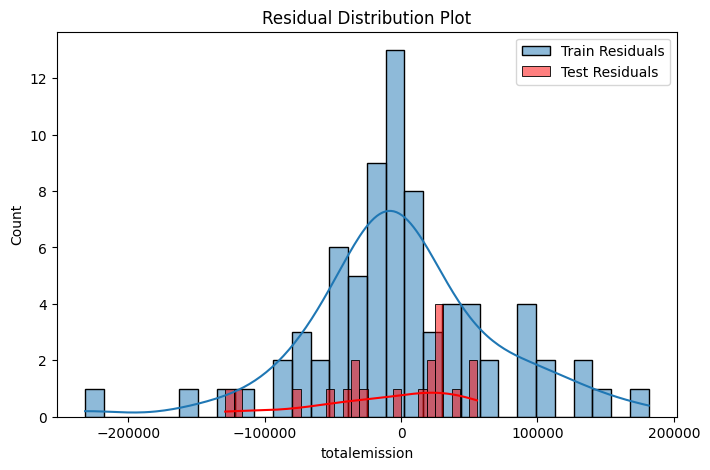

In [37]:
plt.figure(figsize=(8, 5))
sns.histplot(y_train - lr.predict(X_train_scaled), bins=30, kde=True, label="Train Residuals")
sns.histplot(y_test - lr.predict(X_test_scaled), bins=30, kde=True, label="Test Residuals", color="r")
plt.legend()
plt.title("Residual Distribution Plot")
plt.show()

In [38]:
ridge = evaluate_model(Ridge(alpha=10), "Ridge Regression", X_train_scaled, X_test_scaled, y_train, y_test)
lasso = evaluate_model(Lasso(alpha=0.01), "Lasso Regression", X_train_scaled, X_test_scaled, y_train, y_test)

Ridge Regression:
MAE: 108939.22, MSE: 19282930486.38, RMSE: 138862.99, R²: 0.9833

Lasso Regression:
MAE: 43562.84, MSE: 2900912573.85, RMSE: 53860.12, R²: 0.9975



In [39]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [40]:
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

lr_poly = evaluate_model(LinearRegression(), "Polynomial Regression (Degree 2)", X_train_poly_scaled, X_test_poly_scaled, y_train, y_test)

Polynomial Regression (Degree 2):
MAE: 62239.65, MSE: 5381664864.46, RMSE: 73359.83, R²: 0.9953



### Hyperparameter tuning of Lasso

In [41]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
best_alpha = None
best_r2 = -np.inf
results = []

In [42]:
for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_pred = lasso.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    
    results.append((alpha, mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), r2))

    if r2 > best_r2:
        best_r2 = r2
        best_alpha = alpha

In [43]:
results_df = pd.DataFrame(results, columns=["Alpha", "MAE", "MSE", "RMSE", "R2 Score"])
print("Hyperparameter Tuning Results:\n", results_df)

Hyperparameter Tuning Results:
      Alpha           MAE           MSE          RMSE  R2 Score
0   0.0001  43562.848972  2.900913e+09  53860.127795  0.997489
1   0.0010  43562.848279  2.900913e+09  53860.127126  0.997489
2   0.0100  43562.841353  2.900913e+09  53860.120440  0.997489
3   0.1000  43562.772110  2.900905e+09  53860.053590  0.997489
4   1.0000  43562.079946  2.900833e+09  53859.385315  0.997489
5  10.0000  43555.171254  2.900115e+09  53852.717085  0.997490


In [44]:
final_lasso = Lasso(alpha=best_alpha, max_iter=10000)
final_lasso.fit(X_train_scaled, y_train)
y_final_pred = final_lasso.predict(X_test_scaled)

In [45]:
def evaluate_model(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}:\nMAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}\n")

In [46]:
evaluate_model(f"Lasso Regression (Best Alpha = {best_alpha})", y_test, y_final_pred)

Lasso Regression (Best Alpha = 10):
MAE: 43555.17, MSE: 2900115137.41, RMSE: 53852.72, R²: 0.9975



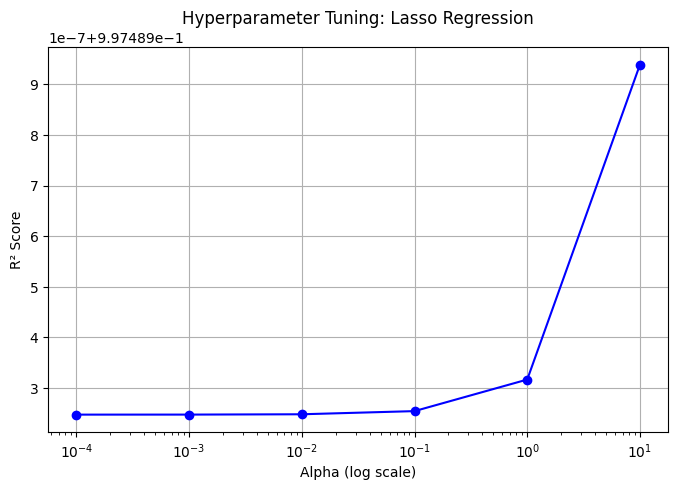

In [47]:
plt.figure(figsize=(8, 5))
plt.plot(results_df["Alpha"], results_df["R2 Score"], marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("R² Score")
plt.title("Hyperparameter Tuning: Lasso Regression")
plt.grid(True)
plt.show()

In [52]:
import joblib

joblib.dump(final_lasso, "lasso_model.pkl")

loaded_model = joblib.load("lasso_model.pkl")

y_loaded_pred = loaded_model.predict(X_test_scaled)
evaluate_model("Loaded Lasso Model", y_test, y_loaded_pred)
print(f"{y_test} - {y_loaded_pred}")


Loaded Lasso Model:
MAE: 43555.17, MSE: 2900115137.41, RMSE: 53852.72, R²: 0.9975

40    1755197.95
22    1036788.74
55     736390.64
72     528376.49
0     2647902.63
26    3590273.56
39    1755197.95
67    1569271.62
10    3394434.14
44    2320679.16
83     994930.68
35    3137124.04
90    3099651.13
62    1506795.85
12     482172.72
4     1496548.92
18     627297.10
28    3946419.94
49    2214399.58
Name: totalemission, dtype: float64 - [1731318.72040521 1042508.15572241  707072.35504536  501519.96819737
 2766267.93896369 3614711.73563013 1733209.17780984 1603902.39286427
 3444175.38122238 2353580.6576274   981322.76124308 3266130.23215611
 3062106.37010325 1476139.21693807  522779.26327603 1574369.30113762
  601996.18860222 3890739.12771279 2164914.69870783]
